## Model Pipeline CATS 12

### Lucas Jollie, Michelle Klein, Maaike Scholten, Folkert Stijnman

1. Extract features based on Chi Squared test and literature
2. Validate Naive Bayes, Random Forest, MLP
3. Visualise in boxplot
4. Train model and output predictions/model

In [139]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

# 1 Load data and important genes

import pandas as pd

temp_list = []

with open("train_call.txt", 'r') as temp:
    for line in temp:
        temp_list.append(line.split())

columns_temp = temp_list[0]
columns_temp = [x.replace("\"", "") for x in columns_temp]

df_train = pd.DataFrame(temp_list[1:], columns=columns_temp)
X = df_train.drop(['Chromosome', 'Start','End', 'Nclone'], axis=1)
X = X.transpose()

labels = []

with open("Train_clinical.txt", 'r') as temp_labels:
    next(temp_labels)
    for line in temp_labels:
        temp = line.strip()
        temp = temp.split()
        if temp[1].strip("\"") == "HER2+":
            labels.append(1)
        if temp[1].strip("\"") == "HR+":
            labels.append(2)
        if temp[1].strip("\"") == "Triple":
            labels.append(3)

Y = labels

# Find the important genes list here if needed (anyone at VU can view this link): https://docs.google.com/spreadsheets/d/18T0gJ6nX67aa7veYpRTn_0yymVCvFnnllGqiQyqsIcc/edit?usp=sharing
important_genes = [111, 157, 249, 65, 361, 360, 479, 576, 583, 688, 664, 625, 670, 772, 876, 877, 878, 937, 991, 992, 993, 966, 1136, 1137, 1092, 1207, 1234, 1370, 1371, 1387, 1296, 1310, 1583, 1407, 1575, 1513, 1589, 1611, 1697, 1645, 1657, 1725, 1734, 1735, 1865, 1904, 1911, 2017, 1965, 2015, 2016, 2207, 2074, 2075, 2306, 2184, 2135, 2136, 2200, 2201, 2071, 2160, 2161, 2446, 2681, 2682, 2683, 2684, 2685, 2732, 2744, 2794, 2822]
            
print(X)
print(Y)
print("The regions found in the literature were: ", important_genes)

          0    1    2    3    4    5    6    7    8    9     ... 2824 2825  \
Array.129    0    0    0    0    0    0    0    0    0    0  ...    2    2   
Array.34     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.67     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.24     0    0    0    0    0    0    0   -1    0    0  ...    0    0   
Array.22     0    0    0    0    0    0    0    0    0    0  ...    1    1   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Array.10     0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.123    0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.100    0    0    0    0    0    0    0    0    0    0  ...    1    1   
Array.134   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1  ...    1    1   
Array.130    0    0    0    0    0    0    0    0    0    0  ...    1    1   

          2826 2827 2828 2829 2830 2831 2832 2833  
Array.129  

In [140]:
## FEATURE SELECTION

#Loading data
patients = X.values.tolist()

# we need to shift the features by 1 since the chi2 function does not take non-negative values
patients_shift = []

for patient in patients:
    x = []
    for feature in patient:
        x.append(int(feature) + 1)
    patients_shift.append(x)

chi, p_val = chi2(patients_shift, Y)

imp_genes_p_values = []

for i, j in enumerate(important_genes):
    if p_val[j] >= 0.05:
        imp_genes_p_values.append([imp_genes[i][0], j, p_val[j], "No"])
    else:
        imp_genes_p_values.append([imp_genes[i][0], j, p_val[j], "Yes"])
    

important_genes_scores = pd.DataFrame(imp_genes_p_values, columns=["Gene", "Region number", "P-value", "Yes/No"])
pd.set_option('display.max_rows', 75)
print(important_genes_scores)

X_feature_selected = X

threshold = 0.05
for i, val in enumerate(p_val):
    if val >= threshold and i not in important_genes:
        X_feature_selected = X_feature_selected.drop([i], axis=1)
        
X = X_feature_selected
number_of_features = len(X.values.tolist()[0])
print("Number of features = {}".format(number_of_features))

                 Gene  Region number       P-value Yes/No
0              DIRAS3            111  6.897062e-01     No
1              PTPN22            157  7.287985e-01     No
2                 AGT            249  9.791761e-01     No
3               CLSPN             65  5.039604e-01     No
4   BARD1/CASP8/CTLA4            361  8.022867e-01     No
5               SF3B1            360  8.717109e-01     No
6              PIK3CA            479  4.007464e-01     No
7               NFKB1            576  8.076397e-01     No
8                FGF2            583  8.076397e-01     No
9               RAD50            688  1.138701e-01     No
10             MAP3K1            664  1.569463e-01     No
11               TERT            625  9.757757e-01     No
12             PIK3R1            670  4.250528e-02    Yes
13              CCND3            772  1.568220e-01     No
14               ESR1            876  4.297669e-01     No
15               ESR1            877  3.435048e-01     No
16            

In [9]:
# validation scheme

def nested_cross_validation(MODEL, PARAMS, X, Y, NUM_TRIALS):
    nested_scores = []
    
    for i in range(NUM_TRIALS):
        print("Running Trial {}...".format(i + 1))
        # K Fold inner & outer loop
        inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
        outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=i)
        
        # one vs. rest approach
        model_to_set = OneVsRestClassifier(MODEL)
        
        model = GridSearchCV(estimator=model_to_set, param_grid=PARAMS, cv=inner_cv, n_jobs=2)
        nested_score = cross_val_score(model, X=X, y=Y, cv=outer_cv)
        nested_scores.append([nested_score.mean(), nested_score.std()])
        print(nested_score.mean(), nested_score.std())
        
    return nested_scores

In [142]:
# Naive Bayes

nb_nested = []

for i in range(100):
    print("Running Trial {}...".format(i + 1))
    cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    nb = OneVsRestClassifier(GaussianNB())
    nested_score = cross_val_score(nb, X=X, y=Y, cv=cv_folds)
    print(nested_score.mean(), nested_score.std())
    nb_nested.append([nested_score.mean(), nested_score.std()])

Running Trial 1...
0.8099999999999999 0.09165151389911684
Running Trial 2...
0.8099999999999999 0.13564659966250533
Running Trial 3...
0.8300000000000001 0.05099019513592784
Running Trial 4...
0.8099999999999999 0.08000000000000003
Running Trial 5...
0.8099999999999999 0.058309518948453015
Running Trial 6...
0.79 0.058309518948453015
Running Trial 7...
0.8099999999999999 0.07348469228349537
Running Trial 8...
0.8400000000000001 0.08602325267042628
Running Trial 9...
0.78 0.10295630140987
Running Trial 10...
0.8 0.05477225575051662
Running Trial 11...
0.8399999999999999 0.07999999999999999
Running Trial 12...
0.86 0.07999999999999999
Running Trial 13...
0.8 0.10488088481701516
Running Trial 14...
0.8099999999999999 0.12409673645990857
Running Trial 15...
0.8 0.0632455532033676
Running Trial 16...
0.8300000000000001 0.0678232998312527
Running Trial 17...
0.8400000000000001 0.12409673645990854
Running Trial 18...
0.8400000000000001 0.048989794855663564
Running Trial 19...
0.82 0.081240384

In [47]:
# Random Forest

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10, dtype=int)]
max_features = ['auto', 'sqrt']

parameters = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features}

rf = RandomForestClassifier()

rf_nested = nested_cross_validation(rf, parameters, X, Y, 100)

Running Trial 1...
0.7600000000000001 0.04898979485566356
Running Trial 2...
0.71 0.18841443681416772
Running Trial 3...
0.77 0.07141428428542847
Running Trial 4...
0.7200000000000001 0.0748331477354788
Running Trial 5...
0.74 0.1183215956619923
Running Trial 6...
0.8 0.06324555320336758
Running Trial 7...
0.75 0.09110433579144296
Running Trial 8...
0.7900000000000001 0.08660254037844387
Running Trial 9...
0.78 0.060000000000000005
Running Trial 10...
0.73 0.07141428428542851
Running Trial 11...
0.78 0.06
Running Trial 12...
0.77 0.07681145747868608
Running Trial 13...
0.75 0.08660254037844387
Running Trial 14...
0.8 0.16248076809271922
Running Trial 15...
0.76 0.07483314773547882
Running Trial 16...
0.77 0.08660254037844387
Running Trial 17...
0.7500000000000001 0.091104335791443
Running Trial 18...
0.78 0.060000000000000005
Running Trial 19...
0.76 0.15748015748023622
Running Trial 20...
0.73 0.08660254037844387
Running Trial 21...
0.77 0.051961524227066326
Running Trial 22...
0.73 0

In [48]:
# Multi Layer Perceptron

parameters = {'estimator__solver': ['lbfgs'], 
              'estimator__max_iter': [500, 1000, 1500, 2000, 2500, 3000], 
              'estimator__hidden_layer_sizes':np.linspace(10, 200, 10, dtype=int)
             }

mlp = MLPClassifier()

mlp_nested = nested_cross_validation(mlp, parameters, X, Y, 100)

Running Trial 1...
0.8500000000000001 0.08185352771872453
Running Trial 2...
0.82 0.04472135954999579
Running Trial 3...
0.81 0.05916079783099617
Running Trial 4...
0.84 0.028284271247461888
Running Trial 5...
0.8500000000000001 0.06557438524301998
Running Trial 6...
0.8599999999999999 0.08246211251235319
Running Trial 7...
0.85 0.0768114574786861
Running Trial 8...
0.8600000000000001 0.060000000000000005
Running Trial 9...
0.88 0.028284271247461926
Running Trial 10...
0.86 0.060000000000000005
Running Trial 11...
0.8300000000000001 0.05916079783099616
Running Trial 12...
0.87 0.051961524227066326
Running Trial 13...
0.8699999999999999 0.091104335791443
Running Trial 14...
0.84 0.12328828005937952
Running Trial 15...
0.83 0.07141428428542852
Running Trial 16...
0.84 0.028284271247461888
Running Trial 17...
0.8400000000000001 0.028284271247461888
Running Trial 18...
0.84 0.04898979485566356
Running Trial 19...
0.85 0.033166247903553984
Running Trial 20...
0.8399999999999999 0.0848528137

In [143]:
# Save results

result_list = []
result_columns = ["Model", "Trial", "Accuracy", "Std_dev"]


for i in range(100):
    result_list.append(["NB", i, nb_nested[i][0], nb_nested[i][1]])
    
nb_df = pd.DataFrame(result_list,columns=result_columns)

nb_df.to_csv("NB_results")

result_list = []
result_columns = ["Model", "Trial", "Accuracy", "Std_dev"]

for i in range(100):
    result_list.append(["RF", i, rf_nested[i][0], rf_nested[i][1]])
    
rf_df = pd.DataFrame(result_list,columns=result_columns)

rf_df.to_csv("RF_results")

result_list = []
result_columns = ["Model", "Trial", "Accuracy", "Std_dev"]

for i in range(100):
    result_list.append(["MLP", i, mlp_nested[i][0], mlp_nested[i][1]])
    
mlp_df = pd.DataFrame(result_list,columns=result_columns)

mlp_df.to_csv("MLP_results")

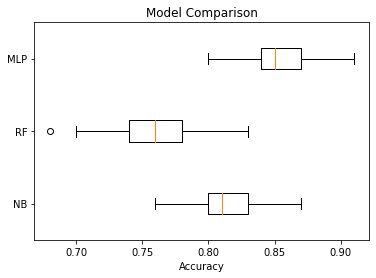

NB average:  0.8143
RF average:  0.7614
MLP average:  0.8541


In [144]:
# 3. Visualise boxplot

def read_results(csvfile):
    results = []

    with open(csvfile, "r") as csv_file:
        next(csv_file)
        for line in csv_file:
            temp = line.strip()
            temp = temp.split(",")
            model = temp[1]
            results.append(float(temp[-2]))
        
    return model, results

mod1, res1 = read_results("NB_results")
mod2, res2 = read_results("RF_results")
mod3, res3 = read_results("MLP_results")
# res4 = all_scores

plt.boxplot([res1, res2, res3], vert = 0, labels=["NB", "RF", "MLP"])
plt.title("Model Comparison")
plt.xlabel("Accuracy")
plt.savefig("boxplot.png", dpi=300)
plt.show()

print("NB average: ", np.average(np.array(nb_nested)[:,0]))
print("RF average: ", np.average(np.array(rf_nested)[:,0]))
print("MLP average: ", np.average(np.array(mlp_nested)[:,0]))

Feature ranking:
1. feature 2184 (0.045021)
2. feature 2223 (0.007394)
3. feature 854 (0.007225)
4. feature 2213 (0.005273)
5. feature 2205 (0.005061)
6. feature 744 (0.004983)
7. feature 849 (0.004852)
8. feature 2104 (0.004329)
9. feature 1065 (0.004279)
10. feature 842 (0.004258)
11. feature 2224 (0.004163)
12. feature 2735 (0.004163)
13. feature 2751 (0.003794)
14. feature 1657 (0.003745)
15. feature 2214 (0.003635)
16. feature 486 (0.003634)
17. feature 839 (0.003607)
18. feature 1909 (0.003435)
19. feature 1973 (0.003401)
20. feature 2209 (0.003386)
21. feature 1027 (0.003360)
22. feature 864 (0.003322)
23. feature 2020 (0.003273)
24. feature 2207 (0.003145)
25. feature 746 (0.003112)
26. feature 1000 (0.003096)
27. feature 1670 (0.002996)
28. feature 2210 (0.002980)
29. feature 386 (0.002874)
30. feature 1957 (0.002732)
31. feature 2113 (0.002723)
32. feature 485 (0.002682)
33. feature 2732 (0.002675)
34. feature 2753 (0.002663)
35. feature 1068 (0.002632)
36. feature 2105 (0.00

ValueError: shape mismatch: objects cannot be broadcast to a single shape

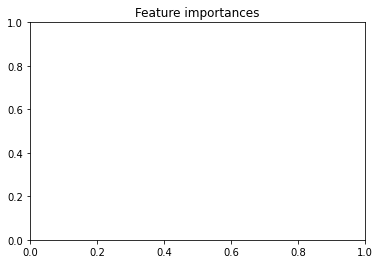

In [145]:
# Find most significant feature by using Random Forest feature importance

X_total = df_train.drop(['Chromosome', 'Start','End', 'Nclone'], axis=1)
X_total = X_total.transpose()

originalclass = []
predictedclass = []

forest = RandomForestClassifier(n_estimators=100)
# temp = evaluate_model(random_forest, X, Y)

forest.fit(X_total, Y)
# print(random_forest.feature_importances_.max())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [193]:
# Load validation set and take features

temp_list = []

with open("Validation_call.txt", 'r') as temp:
    for line in temp:
        temp_list.append(line.split())

columns_temp = temp_list[0]
columns_temp = [x.replace("\"", "") for x in columns_temp]

df_test = pd.DataFrame(temp_list[1:], columns=columns_temp)
test_set = df_test.drop(['Chromosome', 'Start','End', 'Nclone'], axis=1)
test_set = test_set.transpose()

for i, val in enumerate(p_val):
    if val >= threshold and i not in important_genes:
        test_set = test_set.drop([i], axis=1)
        
patient_ids = test_set.index.values

In [148]:
# Train and predict with MLP-model 100 times

prediction_total = []

for i in range(100):
    print("Trial {}".format(i + 1))
    mlp = MLPClassifier()

    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)

    onevsrest_mlp = OneVsRestClassifier(mlp)

    model = RandomizedSearchCV(estimator=onevsrest_mlp, param_distributions=parameters_mlp, cv=folds, n_jobs=2)
    model.fit(X, Y)
    predictions = model.predict(test_set)
    prediction_total.append(predictions)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 12
Trial 13


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 14
Trial 15
Trial 16


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 17
Trial 18


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 19


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 27


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 28
Trial 29
Trial 30
Trial 31
Trial 32
Trial 33


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 34
Trial 35
Trial 36
Trial 37
Trial 38
Trial 39
Trial 40
Trial 41


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 42


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 43
Trial 44


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 45


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 46
Trial 47
Trial 48
Trial 49
Trial 50


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 51
Trial 52
Trial 53


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 54
Trial 55
Trial 56
Trial 57
Trial 58
Trial 59
Trial 60
Trial 61
Trial 62
Trial 63
Trial 64
Trial 65
Trial 66


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 67
Trial 68
Trial 69
Trial 70
Trial 71
Trial 72
Trial 73
Trial 74


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 75
Trial 76
Trial 77
Trial 78
Trial 79
Trial 80
Trial 81
Trial 82
Trial 83
Trial 84
Trial 85
Trial 86
Trial 87


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 88
Trial 89
Trial 90


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 91
Trial 92
Trial 93
Trial 94
Trial 95
Trial 96
Trial 97


C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\folke\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Trial 98
Trial 99
Trial 100


In [194]:
output_temp = []
predictions = []

for i in range(57):
    certainty = "Uncertain"
    
    temp = (np.array(prediction_total)[:,i])
    temp1 = 0
    temp2 = 0
    temp3 = 0
    for j in temp:
        if j == 1:
            temp1 += 1
        if j == 2:
            temp2 += 1
        if j == 3:
            temp3 += 1
    
    if temp1 >= 80 or temp2 >= 80 or temp3 >= 80:
        certainty = "Certain"
    
    output_temp.append([patient_ids[i], temp1 / 100, temp2 / 100, temp3 / 100, certainty])
    predictions.append(np.argmax([temp1, temp2, temp3]) + 1)

total_mlp = pd.DataFrame(output_temp, columns=["Patient", "HR+", "HER2+", "Triple Neg", "Certain?"])

In [220]:
for i, p in enumerate(prediction_total):
    if np.count_nonzero(predictions - p) == 0:
        print(i)

76


In [221]:
parameters_mlp = {'estimator__activation':['identity', 'logistic', 'tanh', 'relu'],
              'estimator__solver': ['lbfgs', 'sgd', 'adam'], 
              'estimator__max_iter': [100, 250, 500, 1000, 1500, 2000, 2500, 3000], 
              'estimator__hidden_layer_sizes':np.linspace(10, 200, 20, dtype=int)
             }

mlp = MLPClassifier()

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=76)

onevsrest_mlp = OneVsRestClassifier(mlp)

model = RandomizedSearchCV(estimator=onevsrest_mlp, param_distributions=parameters_mlp, cv=folds, n_jobs=2)
model.fit(X, Y)
predictions = model.predict(test_set)

In [223]:
output_preds = []

for i, pred in enumerate(predictions):
    if pred == 1:
        output_preds.append([patient_ids[i],"HER2+"])
    if pred == 2:
        output_preds.append([patient_ids[i],"HR+"])
    if pred == 3:
        output_preds.append([patient_ids[i],"Triple Neg"])

file1 = open("predictions.txt","w") 
        
file1.write("\"Sample\" \t \"Subgroup\"\n")
for i, prediction in enumerate(predictions):
    print(output_preds[i][0], "\t", output_preds[i][1])
    file1.write("\"{0}\" \t \"{1}\"\n".format(output_preds[i][0], output_preds[i][1]))

Array.1 	 HR+
Array.61 	 HR+
Array.70 	 Triple Neg
Array.14 	 HER2+
Array.91 	 Triple Neg
Array.58 	 HER2+
Array.140 	 HER2+
Array.20 	 HR+
Array.133 	 Triple Neg
Array.77 	 HER2+
Array.131 	 HER2+
Array.84 	 HR+
Array.44 	 Triple Neg
Array.41 	 HER2+
Array.29 	 HR+
Array.150 	 HER2+
Array.151 	 HR+
Array.132 	 HR+
Array.32 	 HR+
Array.11 	 HR+
Array.156 	 Triple Neg
Array.80 	 HER2+
Array.9 	 Triple Neg
Array.3 	 HR+
Array.136 	 HR+
Array.46 	 HER2+
Array.109 	 HER2+
Array.103 	 Triple Neg
Array.97 	 HR+
Array.40 	 HR+
Array.147 	 HER2+
Array.161 	 Triple Neg
Array.127 	 Triple Neg
Array.119 	 Triple Neg
Array.157 	 HER2+
Array.54 	 HER2+
Array.115 	 HR+
Array.121 	 HER2+
Array.122 	 HER2+
Array.158 	 HER2+
Array.87 	 HER2+
Array.28 	 HER2+
Array.45 	 HR+
Array.155 	 HR+
Array.12 	 Triple Neg
Array.74 	 HER2+
Array.26 	 HR+
Array.120 	 HER2+
Array.108 	 HR+
Array.81 	 HER2+
Array.126 	 HR+
Array.92 	 HR+
Array.160 	 Triple Neg
Array.66 	 Triple Neg
Array.83 	 HR+
Array.128 	 HER2+
Arr

In [225]:
# Dump model

pkl_filename = "cats_12_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)